In [ ]:
!pip install torch torchvision torchaudio pytorch-lightning diffusers transformers accelerate timm albumentations opencv-python scikit-image torchmetrics matplotlib pandas pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 65.4 MB/s eta 0:00:00


In [ ]:
!pip install datasets jsonlines

In [ ]:
!pip install torch torchvision torchaudio pytorch-lightning diffusers transformers accelerate timm albumentations opencv-python scikit-image torchmetrics matplotlib pandas pillow datasets jsonlines

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

CUDA available: True
GPU: Tesla T4
Memory: 14.74 GB


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


🚀 Starting Tamil-Brahmi Restoration Training (Stage 1)
Device: gpu
Precision: 16-mixed
Dataset already exists at /content/dummy_brahmi_dataset. Skipping creation.

🔧 Training Restoration Model


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type        | Params | Mode 
---------------------------------------------
0 | unet | UNet2DModel | 16.5 M | train
---------------------------------------------
16.5 M    Trainable params
0         Non-trainable params
16.5 M    Total params
65.956    Total estimated model params size (MB)
179       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


✅ Best restorer model: /content/logs/restorer/version_1/checkpoints/epoch=4-step=35.ckpt

📊 Evaluating Restoration Model

📈 Stage 1 Results:
   Restoration PSNR: 22.0718
   Restoration SSIM: 0.8244


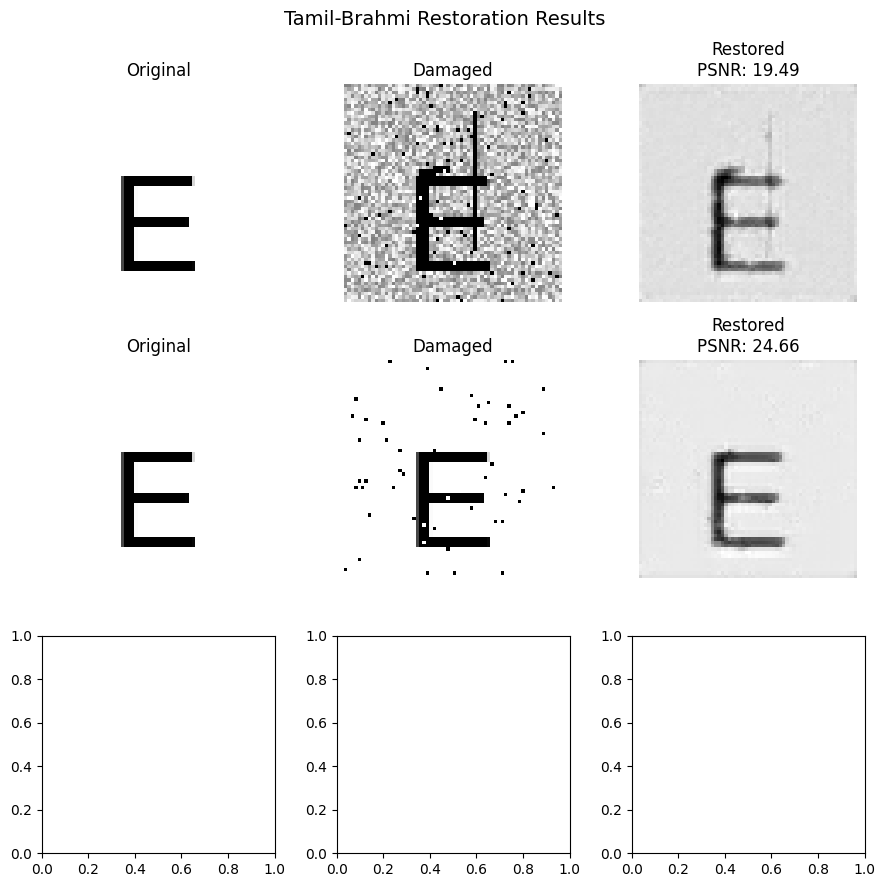

In [ ]:
import os
import json
import gc
from pathlib import Path
from typing import Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

from PIL import Image, ImageDraw, ImageFont
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
from skimage.draw import line_aa
import matplotlib.pyplot as plt

from diffusers import UNet2DModel


# --- Configuration ---
class Config:
    IMG_SIZE = 64
    IMG_CHANNELS = 1
    VOCAB = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    RESTORER_EPOCHS = 5
    RESTORER_LR = 1e-4
    RESTORER_BATCH_SIZE = 16
    NUM_WORKERS = 2
    ACCELERATOR = "gpu" if torch.cuda.is_available() else "cpu"
    DEVICES = 1
    PRECISION = "16-mixed" if torch.cuda.is_available() else "32"

# --- Memory Management Utilities ---
def cleanup_memory():
    """Clear GPU and system memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- Step 1: Dummy Dataset Generation ---
def create_dummy_dataset(root_path: Path, num_samples: int = 100):
    """Generates a dummy dataset of character images and labels."""
    if root_path.exists():
        print(f"Dataset already exists at {root_path}. Skipping creation.")
        return

    print(f"Creating dummy dataset at {root_path}...")
    font = None
    font_options = [
        "/System/Library/Fonts/Arial.ttf",
        "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",
        "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
    ]

    for font_path in font_options:
        try:
            if os.path.exists(font_path):
                font = ImageFont.truetype(font_path, size=40)
                break
        except:
            continue

    if font is None:
        print("Using default font - characters may appear as boxes")
        font = ImageFont.load_default()

    for split in ["train", "val", "test"]:
        split_path = root_path / split
        clean_path = split_path / "clean"
        augmented_path = split_path / "augmented"

        clean_path.mkdir(parents=True, exist_ok=True)
        augmented_path.mkdir(parents=True, exist_ok=True)

        labels = {}
        num_split_samples = num_samples if split == "train" else num_samples // 4

        for i in range(num_split_samples):
            char = np.random.choice(Config.VOCAB)
            clean_img = Image.new("L", (Config.IMG_SIZE, Config.IMG_SIZE), color="white")
            draw = ImageDraw.Draw(clean_img)

            try:
                bbox = draw.textbbox((0, 0), char, font=font)
                w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
                x = (Config.IMG_SIZE - w) // 2
                y = (Config.IMG_SIZE - h) // 2
                draw.text((x, y), char, font=font, fill="black")
            except:
                draw.text((Config.IMG_SIZE//4, Config.IMG_SIZE//4), char, font=font, fill="black")

            augmented_img = T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))(clean_img)
            filename = f"char_{i}.png"
            clean_img.save(clean_path / filename)
            augmented_img.save(augmented_path / filename)
            labels[filename] = {"brahmi_text": char, "tamil_text": char}

        with open(split_path / "labels.json", "w") as f:
            json.dump(labels, f, indent=2)
    print("Dummy dataset created successfully.")

# --- Step 2: Archaeological Noise Generator ---
class ArchaeologicalNoiseGenerator:
    """Applies domain-specific noise to simulate archaeological damage."""
    def __init__(self, crack_prob=0.3, fade_prob=0.5, noise_prob=0.7):
        self.crack_prob = crack_prob
        self.fade_prob = fade_prob
        self.noise_prob = noise_prob

    def _add_cracks(self, img_np: np.ndarray) -> np.ndarray:
        h, w = img_np.shape
        for _ in range(np.random.randint(1, 3)):
            x1, y1 = np.random.randint(0, w), np.random.randint(0, h)
            x2, y2 = np.random.randint(0, w), np.random.randint(0, h)
            rr, cc, val = line_aa(y1, x1, y2, x2)
            valid_indices = (rr >= 0) & (rr < h) & (cc >= 0) & (cc < w)
            img_np[rr[valid_indices], cc[valid_indices]] = 0
        return img_np

    def _add_fading(self, img_np: np.ndarray) -> np.ndarray:
        fade_mask = np.random.rand(*img_np.shape) * 0.5 + 0.5
        return np.clip(img_np * fade_mask, 0, 1)

    def _add_stone_noise(self, img_np: np.ndarray) -> np.ndarray:
        return random_noise(img_np, mode='s&p', amount=np.random.uniform(0.01, 0.05))

    def __call__(self, img_tensor: torch.Tensor) -> torch.Tensor:
        device = img_tensor.device
        img_np = img_tensor.squeeze(0).cpu().numpy()
        if np.random.rand() < self.crack_prob:
            img_np = self._add_cracks(img_np)
        if np.random.rand() < self.fade_prob:
            img_np = self._add_fading(img_np)
        if np.random.rand() < self.noise_prob:
            img_np = self._add_stone_noise(img_np)
        return torch.from_numpy(img_np).unsqueeze(0).float().to(device)

# --- Step 3: Data Module ---
class TamilBrahmiDataModule(pl.LightningDataModule):
    """Handles data loading for restoration stage."""
    def __init__(self, data_path: str, batch_size: int, num_workers: int):
        super().__init__()
        self.data_path = Path(data_path)
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage: Optional[str] = None):
        self.train_ds = TamilBrahmiDataset(self.data_path / "train")
        self.val_ds = TamilBrahmiDataset(self.data_path / "val")
        self.test_ds = TamilBrahmiDataset(self.data_path / "test")

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True
        )

class TamilBrahmiDataset(Dataset):
    """Custom dataset to load clean and augmented images."""
    def __init__(self, split_path: Path):
        super().__init__()
        self.clean_img_dir = split_path / "clean"
        self.aug_img_dir = split_path / "augmented"
        with open(split_path / "labels.json", "r") as f:
            self.labels = json.load(f)
        self.filenames = list(self.labels.keys())

        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Dict:
        filename = self.filenames[idx]
        clean_img_path = self.clean_img_dir / filename
        aug_img_path = self.aug_img_dir / filename

        clean_img = Image.open(clean_img_path)
        aug_img = Image.open(aug_img_path)

        text_label = self.labels[filename]["brahmi_text"]

        return {
            "clean_image": self.transform(clean_img),
            "augmented_image": self.transform(aug_img),
            "text": text_label
        }

# --- Step 4: Restoration Model (U-Net) ---
class TamilBrahmiRestorer(pl.LightningModule):
    """A LightningModule for restoring degraded character images using a U-Net."""
    def __init__(self, learning_rate: float = Config.RESTORER_LR):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        self.unet = UNet2DModel(
            sample_size=Config.IMG_SIZE,
            in_channels=Config.IMG_CHANNELS,
            out_channels=Config.IMG_CHANNELS,
            layers_per_block=1,
            block_out_channels=(64, 128, 256, 256),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
        )
        self.noise_generator = ArchaeologicalNoiseGenerator()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.unet(x, timestep=0).sample

    def training_step(self, batch: Dict, batch_idx: int) -> torch.Tensor:
        clean_images = batch["clean_image"]
        damaged_images = torch.stack([
            self.noise_generator(img.cpu()).to(clean_images.device)
            for img in clean_images
        ])
        restored_images = self(damaged_images)
        loss = F.l1_loss(restored_images, clean_images)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch: Dict, batch_idx: int):
        clean_images = batch["clean_image"]
        damaged_images = torch.stack([
            self.noise_generator(img.cpu()).to(clean_images.device)
            for img in clean_images
        ])
        restored_images = self(damaged_images)
        loss = F.l1_loss(restored_images, clean_images)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.RESTORER_EPOCHS)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# --- Evaluation for Stage 1 ---
def evaluate_restorer(restorer, datamodule):
    """Evaluate the restoration model and create visualizations"""
    test_loader = datamodule.test_dataloader()
    psnr_vals, ssim_vals = [], []
    unnormalize = T.Normalize(mean=[-1.0], std=[2.0])

    device = next(restorer.parameters()).device
    restorer.to(device)

    num_viz = 3
    fig, axes = plt.subplots(num_viz, 3, figsize=(9, 3 * num_viz))
    fig.suptitle("Tamil-Brahmi Restoration Results", fontsize=14)
    viz_count = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if batch_idx >= num_viz:
                break
            clean_images = batch["clean_image"].to(device)
            text_labels = batch["text"]
            damaged_images = torch.stack([
                restorer.noise_generator(img.cpu()).to(device)
                for img in clean_images
            ])
            restored_images = restorer(damaged_images)

            if viz_count < num_viz:
                clean_np = unnormalize(clean_images[0:1]).cpu().numpy().squeeze()
                restored_np = unnormalize(restored_images[0:1]).cpu().numpy().squeeze()
                damaged_np = unnormalize(damaged_images[0:1]).cpu().numpy().squeeze()

                p = psnr(clean_np, restored_np, data_range=1.0)
                s = ssim(clean_np, restored_np, data_range=1.0)
                psnr_vals.append(p)
                ssim_vals.append(s)

                ax_row = axes[viz_count] if num_viz > 1 else [axes]
                ax_row[0].imshow(clean_np, cmap='gray')
                ax_row[0].set_title("Original")
                ax_row[0].axis('off')
                ax_row[1].imshow(damaged_np, cmap='gray')
                ax_row[1].set_title("Damaged")
                ax_row[1].axis('off')
                ax_row[2].imshow(restored_np, cmap='gray')
                ax_row[2].set_title(f"Restored\nPSNR: {p:.2f}")
                ax_row[2].axis('off')
                viz_count += 1

    avg_psnr = np.mean(psnr_vals) if psnr_vals else 0
    avg_ssim = np.mean(ssim_vals) if ssim_vals else 0
    print(f"\n📈 Stage 1 Results:")
    print(f"   Restoration PSNR: {avg_psnr:.4f}")
    print(f"   Restoration SSIM: {avg_ssim:.4f}")
    plt.tight_layout()
    plt.show()

# --- Main Training Pipeline for Stage 1 ---
def main(dataset_path: str = "/content/dummy_brahmi_dataset"):
    print("🚀 Starting Tamil-Brahmi Restoration Training (Stage 1)")
    print(f"Device: {Config.ACCELERATOR}")
    print(f"Precision: {Config.PRECISION}")

    create_dummy_dataset(Path(dataset_path))
    cleanup_memory()

    datamodule = TamilBrahmiDataModule(
        data_path=dataset_path,
        batch_size=Config.RESTORER_BATCH_SIZE,
        num_workers=Config.NUM_WORKERS
    )

    print("\n🔧 Training Restoration Model")
    restorer_model = TamilBrahmiRestorer(learning_rate=Config.RESTORER_LR)
    restorer_trainer = pl.Trainer(
        max_epochs=Config.RESTORER_EPOCHS,
        accelerator=Config.ACCELERATOR,
        devices=Config.DEVICES,
        precision=Config.PRECISION,
        logger=CSVLogger("/content/logs", name="restorer"),
        callbacks=[
            ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1),
            TQDMProgressBar(refresh_rate=20)
        ],
        enable_checkpointing=True,
        enable_model_summary=True,
        gradient_clip_val=1.0
    )

    restorer_trainer.fit(restorer_model, datamodule)
    best_restorer_path = restorer_trainer.checkpoint_callback.best_model_path
    print(f"✅ Best restorer model: {best_restorer_path}")

    trained_restorer = TamilBrahmiRestorer.load_from_checkpoint(best_restorer_path)
    trained_restorer.eval()
    cleanup_memory()

    print("\n📊 Evaluating Restoration Model")
    evaluate_restorer(trained_restorer, datamodule)

if __name__ == "__main__":
    main(dataset_path="/content/dummy_brahmi_dataset")

🚀 Starting Tamil-Brahmi Recognition Training (Stage 2)
Device: gpu
Precision: 16-mixed


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



🔍 Training Recognition Model


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'tran

Replacing encoder's first conv layer: Expected 3 channels, but got 1
Updating encoder image size: Expected 224x224, but got 64x64


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params | Mode 
--------------------------------------------------------------
0 | model   | VisionEncoderDecoderModel | 238 M  | train
1 | cer     | CharErrorRate             | 0      | train
2 | val_cer | CharErrorRate             | 0      | train
--------------------------------------------------------------
238 M     Trainable params
0         Non-trainable params
238 M     Total params
954.658   Total estimated model params size (MB)
4         Modules in train mode
462       Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:527: Found 462 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


✅ Best recognizer model: /content/logs/recognizer/version_3/checkpoints/epoch=1-step=14.ckpt


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'tran

Replacing encoder's first conv layer: Expected 3 channels, but got 1
Updating encoder image size: Expected 224x224, but got 64x64

🔄 Loading trained restorer from /content/logs/restorer/version_0/checkpoints/epoch=4-step=35.ckpt

📊 Evaluating Full Pipeline


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



📈 Stage 2 Results:
   Restoration PSNR: 21.0334
   Restoration SSIM: 0.7936
   Recognition CER: 1.0000
   Recognition Accuracy: 0.0000


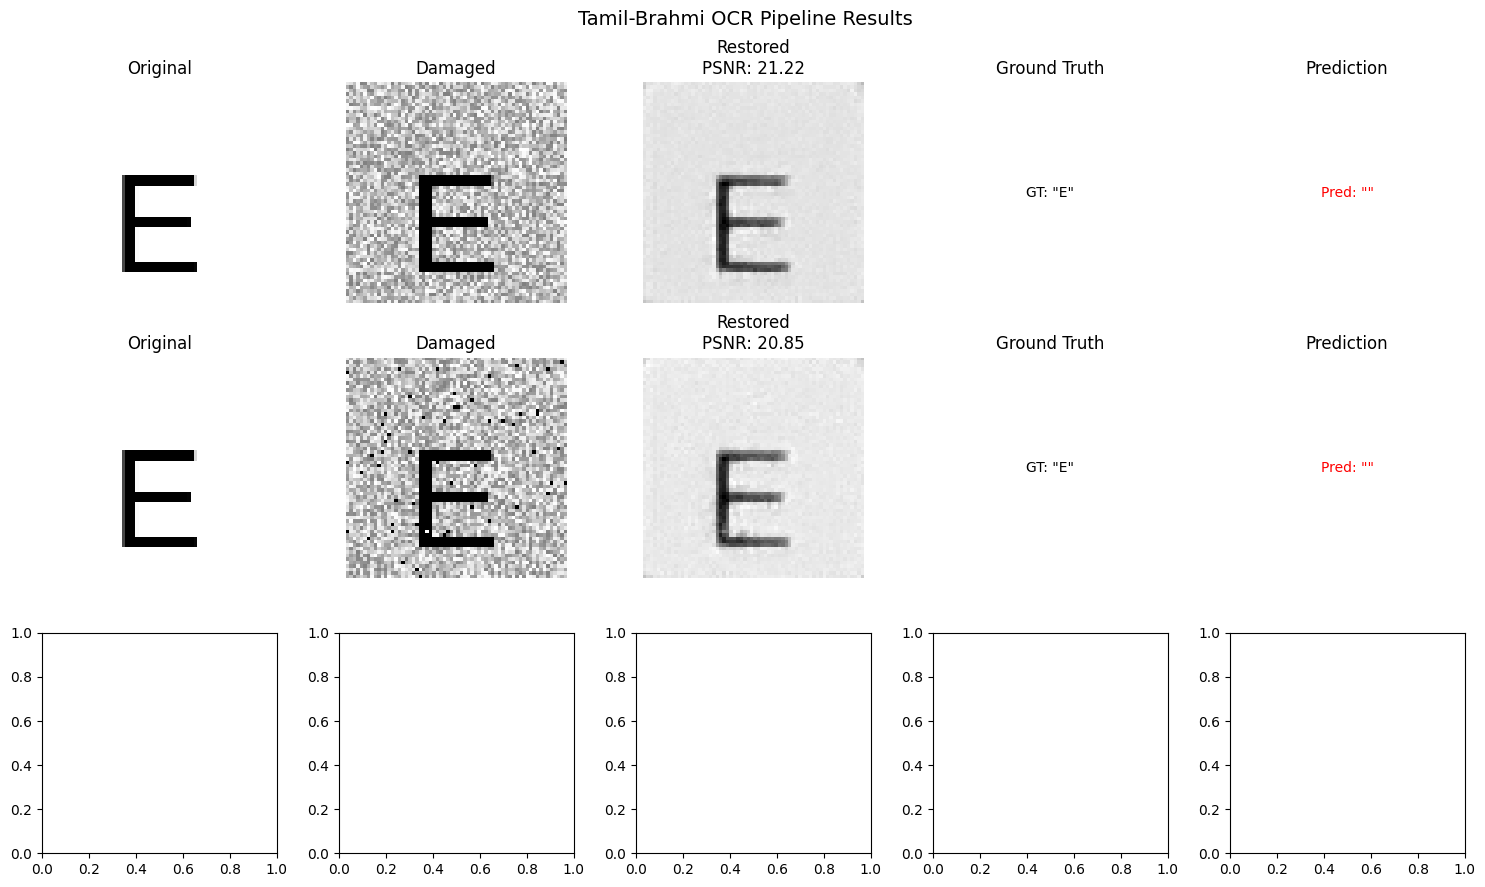

In [ ]:
import os
import json
import gc
from pathlib import Path
from typing import Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

from PIL import Image, ImageDraw, ImageFont
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
from skimage.draw import line_aa
import matplotlib.pyplot as plt

from diffusers import UNet2DModel
from transformers import VisionEncoderDecoderModel, AutoTokenizer
from torchmetrics.text import CharErrorRate

# --- Configuration ---
class Config:
    IMG_SIZE = 64
    IMG_CHANNELS = 1

    VOCAB = ["𑀓", "𑀔", "𑀕", "𑀖", "𑀗", "𑀘", "𑀙", "𑀚", "𑀛", "𑀜",  # ka to dha
             "𑀝", "𑀞", "𑀟", "𑀠", "𑀡", "𑀢", "𑀣", "𑀤", "𑀥", "𑀦",  # na to ma
             "𑀧", "𑀨", "𑀩", "𑀪", "𑀫", ".", ","]
    RECOGNIZER_EPOCHS = 8
    RECOGNIZER_LR = 5e-5
    RECOGNIZER_BATCH_SIZE = 16
    RECOGNIZER_ENCODER = "google/vit-base-patch16-224"
    RECOGNIZER_DECODER = "gpt2"
    NUM_WORKERS = 2
    ACCELERATOR = "gpu" if torch.cuda.is_available() else "cpu"
    DEVICES = 1
    PRECISION = "16-mixed" if torch.cuda.is_available() else "32"

# --- Memory Management Utilities ---
def cleanup_memory():
    """Clear GPU and system memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- Archaeological Noise Generator ---
class ArchaeologicalNoiseGenerator:
    """Applies domain-specific noise to simulate archaeological damage."""
    def __init__(self, crack_prob=0.3, fade_prob=0.5, noise_prob=0.7):
        self.crack_prob = crack_prob
        self.fade_prob = fade_prob
        self.noise_prob = noise_prob

    def _add_cracks(self, img_np: np.ndarray) -> np.ndarray:
        h, w = img_np.shape
        for _ in range(np.random.randint(1, 3)):
            x1, y1 = np.random.randint(0, w), np.random.randint(0, h)
            x2, y2 = np.random.randint(0, w), np.random.randint(0, h)
            rr, cc, val = line_aa(y1, x1, y2, x2)
            valid_indices = (rr >= 0) & (rr < h) & (cc >= 0) & (cc < w)
            img_np[rr[valid_indices], cc[valid_indices]] = 0
        return img_np

    def _add_fading(self, img_np: np.ndarray) -> np.ndarray:
        fade_mask = np.random.rand(*img_np.shape) * 0.5 + 0.5
        return np.clip(img_np * fade_mask, 0, 1)

    def _add_stone_noise(self, img_np: np.ndarray) -> np.ndarray:
        return random_noise(img_np, mode='s&p', amount=np.random.uniform(0.01, 0.05))

    def __call__(self, img_tensor: torch.Tensor) -> torch.Tensor:
        device = img_tensor.device
        img_np = img_tensor.squeeze(0).cpu().numpy()
        if np.random.rand() < self.crack_prob:
            img_np = self._add_cracks(img_np)
        if np.random.rand() < self.fade_prob:
            img_np = self._add_fading(img_np)
        if np.random.rand() < self.noise_prob:
            img_np = self._add_stone_noise(img_np)
        return torch.from_numpy(img_np).unsqueeze(0).float().to(device)

# --- Data Module ---
class TamilBrahmiDataModule(pl.LightningDataModule):
    """Handles data loading for recognition stage."""
    def __init__(self, data_path: str, batch_size: int, num_workers: int):
        super().__init__()
        self.data_path = Path(data_path)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.tokenizer = AutoTokenizer.from_pretrained(Config.RECOGNIZER_DECODER)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def setup(self, stage: Optional[str] = None):
        self.train_ds = TamilBrahmiDataset(self.data_path / "train", self.tokenizer)
        self.val_ds = TamilBrahmiDataset(self.data_path / "val", self.tokenizer)
        self.test_ds = TamilBrahmiDataset(self.data_path / "test", self.tokenizer)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True
        )

class TamilBrahmiDataset(Dataset):
    """Custom dataset to load clean, augmented images and labels."""
    def __init__(self, split_path: Path, tokenizer):
        super().__init__()
        self.clean_img_dir = split_path / "clean"
        self.aug_img_dir = split_path / "augmented"
        with open(split_path / "labels.json", "r") as f:
            self.labels = json.load(f)
        self.filenames = list(self.labels.keys())
        self.tokenizer = tokenizer

        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Dict:
        filename = self.filenames[idx]
        clean_img_path = self.clean_img_dir / filename
        aug_img_path = self.aug_img_dir / filename

        clean_img = Image.open(clean_img_path)
        aug_img = Image.open(aug_img_path)

        text_label = self.labels[filename]["brahmi_text"]
        tokenized_label = self.tokenizer(
            text_label,
            padding="max_length",
            max_length=16,
            return_tensors="pt"
        ).input_ids.squeeze(0)

        return {
            "clean_image": self.transform(clean_img),
            "augmented_image": self.transform(aug_img),
            "labels": tokenized_label,
            "text": text_label
        }

# --- Restoration Model (for loading trained model) ---
class TamilBrahmiRestorer(pl.LightningModule):
    """A LightningModule for restoring degraded character images using a U-Net."""
    def __init__(self, learning_rate: float = Config.RECOGNIZER_LR):
        super().__init__()
        self.unet = UNet2DModel(
            sample_size=Config.IMG_SIZE,
            in_channels=Config.IMG_CHANNELS,
            out_channels=Config.IMG_CHANNELS,
            layers_per_block=1,
            block_out_channels=(64, 128, 256, 256),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
        )
        self.noise_generator = ArchaeologicalNoiseGenerator()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.unet(x, timestep=0).sample

# --- Recognition Model ---
class GOTTamilBrahmi(pl.LightningModule):
    """A LightningModule for recognizing characters from clean images."""
    def __init__(self, learning_rate: float = Config.RECOGNIZER_LR):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        self.model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
            Config.RECOGNIZER_ENCODER, Config.RECOGNIZER_DECODER
        )

        encoder_config = self.model.encoder.config
        expected_channels = encoder_config.num_channels
        if expected_channels != Config.IMG_CHANNELS:
            print(f"Replacing encoder's first conv layer: Expected {expected_channels} channels, but got {Config.IMG_CHANNELS}")
            self.model.encoder.embeddings.patch_embeddings.projection = torch.nn.Conv2d(
                Config.IMG_CHANNELS,
                encoder_config.hidden_size,
                kernel_size=encoder_config.patch_size,
                stride=encoder_config.patch_size
            )
            self.model.encoder.config.num_channels = Config.IMG_CHANNELS
            self.model.encoder.embeddings.patch_embeddings.num_channels = Config.IMG_CHANNELS

        expected_image_size = encoder_config.image_size
        if expected_image_size != Config.IMG_SIZE:
            print(f"Updating encoder image size: Expected {expected_image_size}x{expected_image_size}, but got {Config.IMG_SIZE}x{Config.IMG_SIZE}")
            self.model.encoder.config.image_size = Config.IMG_SIZE
            self.model.encoder.embeddings.patch_embeddings.image_size = (Config.IMG_SIZE, Config.IMG_SIZE)
            num_patches = (Config.IMG_SIZE // encoder_config.patch_size) ** 2
            self.model.encoder.embeddings.position_embeddings = nn.Parameter(
                torch.randn(1, num_patches + 1, encoder_config.hidden_size)
            )

        self.tokenizer = AutoTokenizer.from_pretrained(Config.RECOGNIZER_DECODER)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.config.decoder_start_token_id = self.tokenizer.bos_token_id

        self.cer = CharErrorRate()
        self.val_cer = CharErrorRate()

    def forward(self, pixel_values, labels=None):
        return self.model(pixel_values=pixel_values, labels=labels)

    def training_step(self, batch: Dict, batch_idx: int) -> torch.Tensor:
        images = batch["augmented_image"]
        labels = batch["labels"]
        outputs = self(pixel_values=images, labels=labels)
        loss = outputs.loss
        self.log("train_rec_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch: Dict, batch_idx: int):
        images = batch["augmented_image"]
        labels = batch["labels"]
        text_labels = batch["text"]
        generated_ids = self.model.generate(
            images,
            max_length=16,
            num_beams=2,
            attention_mask=torch.ones_like(labels)
        )
        generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        self.val_cer.update(generated_text, text_labels)
        self.log("val_cer", self.val_cer, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.RECOGNIZER_EPOCHS)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# --- Evaluation for Stage 2 ---
def evaluate_pipeline(restorer, recognizer, datamodule):
    """Evaluate the complete pipeline and create visualizations"""
    test_loader = datamodule.test_dataloader()
    psnr_vals, ssim_vals = [], []
    test_cer = CharErrorRate()
    unnormalize = T.Normalize(mean=[-1.0], std=[2.0])

    device = next(restorer.parameters()).device
    restorer.to(device)
    recognizer.to(device)

    num_viz = 3
    fig, axes = plt.subplots(num_viz, 5, figsize=(15, 3 * num_viz))
    fig.suptitle("Tamil-Brahmi OCR Pipeline Results", fontsize=14)
    viz_count = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if batch_idx >= num_viz:
                break
            clean_images = batch["clean_image"].to(device)
            text_labels = batch["text"]
            damaged_images = torch.stack([
                restorer.noise_generator(img.cpu()).to(device)
                for img in clean_images
            ])
            restored_images = restorer(damaged_images)
            generated_ids = recognizer.model.generate(
                restored_images,
                max_length=16,
                num_beams=1,
                attention_mask=torch.ones_like(batch["labels"])
            )
            predicted_text = recognizer.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            test_cer.update(predicted_text, text_labels)

            if viz_count < num_viz:
                clean_np = unnormalize(clean_images[0:1]).cpu().numpy().squeeze()
                restored_np = unnormalize(restored_images[0:1]).cpu().numpy().squeeze()
                damaged_np = unnormalize(damaged_images[0:1]).cpu().numpy().squeeze()
                p = psnr(clean_np, restored_np, data_range=1.0)
                s = ssim(clean_np, restored_np, data_range=1.0)
                psnr_vals.append(p)
                ssim_vals.append(s)

                ax_row = axes[viz_count] if num_viz > 1 else [axes]
                ax_row[0].imshow(clean_np, cmap='gray')
                ax_row[0].set_title("Original")
                ax_row[0].axis('off')
                ax_row[1].imshow(damaged_np, cmap='gray')
                ax_row[1].set_title("Damaged")
                ax_row[1].axis('off')
                ax_row[2].imshow(restored_np, cmap='gray')
                ax_row[2].set_title(f"Restored\nPSNR: {p:.2f}")
                ax_row[2].axis('off')
                ax_row[3].text(0.5, 0.5, f'GT: "{text_labels[0]}"', ha='center', va='center', fontsize=10)
                ax_row[3].set_title("Ground Truth")
                ax_row[3].axis('off')
                color = 'green' if text_labels[0] == predicted_text[0] else 'red'
                ax_row[4].text(0.5, 0.5, f'Pred: "{predicted_text[0]}"', ha='center', va='center', fontsize=10, color=color)
                ax_row[4].set_title("Prediction")
                ax_row[4].axis('off')
                viz_count += 1

    avg_psnr = np.mean(psnr_vals) if psnr_vals else 0
    avg_ssim = np.mean(ssim_vals) if ssim_vals else 0
    final_cer = test_cer.compute()
    print(f"\n📈 Stage 2 Results:")
    print(f"   Restoration PSNR: {avg_psnr:.4f}")
    print(f"   Restoration SSIM: {avg_ssim:.4f}")
    print(f"   Recognition CER: {final_cer:.4f}")
    print(f"   Recognition Accuracy: {1 - final_cer:.4f}")
    plt.tight_layout()
    plt.show()

# --- Main Training Pipeline for Stage 2 ---
def main(dataset_path: str = "/content/dummy_brahmi_dataset", restorer_checkpoint: str = "/content/logs/restorer/version_7/checkpoints/epoch=4-step=35.ckpt"):
    print("🚀 Starting Tamil-Brahmi Recognition Training (Stage 2)")
    print(f"Device: {Config.ACCELERATOR}")
    print(f"Precision: {Config.PRECISION}")

    cleanup_memory()

    datamodule = TamilBrahmiDataModule(
        data_path=dataset_path,
        batch_size=Config.RECOGNIZER_BATCH_SIZE,
        num_workers=Config.NUM_WORKERS
    )

    print("\n🔍 Training Recognition Model")
    gott_model = GOTTamilBrahmi(learning_rate=Config.RECOGNIZER_LR)
    recognizer_trainer = pl.Trainer(
        max_epochs=Config.RECOGNIZER_EPOCHS,
        accelerator=Config.ACCELERATOR,
        devices=Config.DEVICES,
        precision=Config.PRECISION,
        logger=CSVLogger("/content/logs", name="recognizer"),
        callbacks=[
            ModelCheckpoint(monitor="val_cer", mode="min", save_top_k=1),
            TQDMProgressBar(refresh_rate=20)
        ],
        enable_checkpointing=True,
        gradient_clip_val=1.0
    )

    recognizer_trainer.fit(gott_model, datamodule)
    best_gott_path = recognizer_trainer.checkpoint_callback.best_model_path
    print(f"✅ Best recognizer model: {best_gott_path}")

    trained_recognizer = GOTTamilBrahmi.load_from_checkpoint(best_gott_path)
    trained_recognizer.eval()

    print(f"\n🔄 Loading trained restorer from {restorer_checkpoint}")
    trained_restorer = TamilBrahmiRestorer.load_from_checkpoint(restorer_checkpoint)
    trained_restorer.eval()
    cleanup_memory()

    print("\n📊 Evaluating Full Pipeline")
    evaluate_pipeline(trained_restorer, trained_recognizer, datamodule)

if __name__ == "__main__":
    main(dataset_path="/content/dummy_brahmi_dataset", restorer_checkpoint="/content/logs/restorer/version_0/checkpoints/epoch=4-step=35.ckpt")

🚀 Starting Tamil-Brahmi Restoration Training (Stage 1)
Device: gpu
Precision: 16-mixed
Creating improved dummy dataset at /content/dummy_brahmi_dataset...
Improved dummy dataset created successfully.

🔧 Training Restoration Model


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type        | Params | Mode 
---------------------------------------------
0 | unet | UNet2DModel | 95.9 M | train
---------------------------------------------
95.9 M    Trainable params
0         Non-trainable params
95.9 M    Total params
383.436   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Best restorer model: /content/logs/restorer/version_0/checkpoints/epoch=9-step=160.ckpt

📊 Evaluating Restoration Model

📈 Stage 1 Results:
   Restoration PSNR: 30.4206
   Restoration SSIM: 0.9388


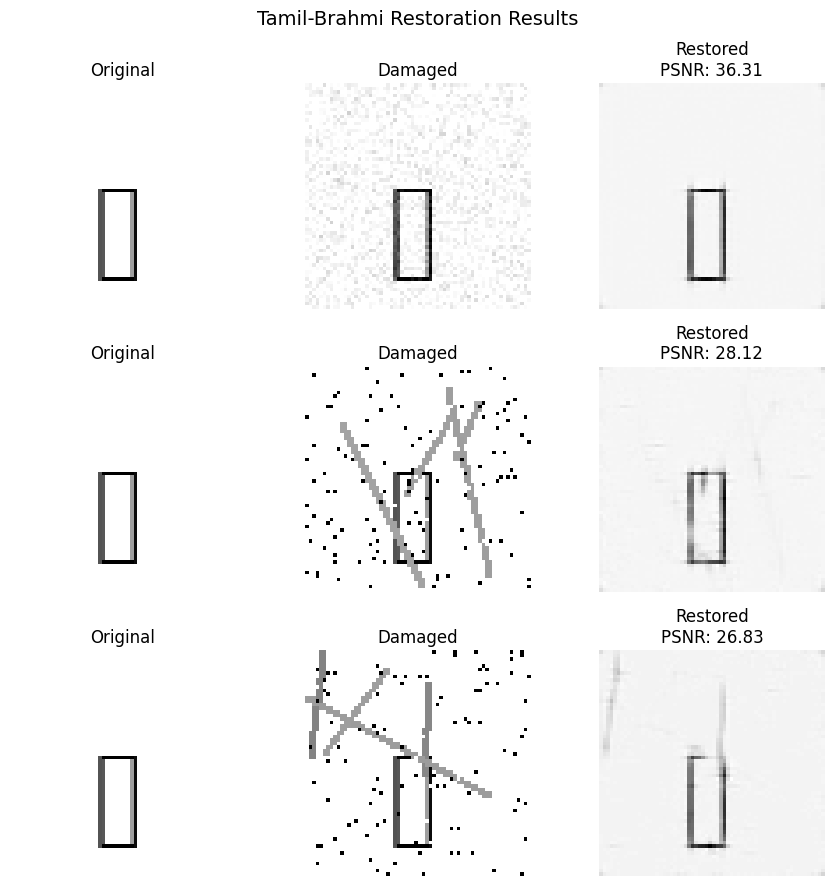

In [ ]:
import os
import json
import gc
from pathlib import Path
from typing import Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

from PIL import Image, ImageDraw, ImageFont
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
from skimage.draw import line_aa
import matplotlib.pyplot as plt

from diffusers import UNet2DModel

# --- Configuration ---
class Config:
    IMG_SIZE = 64
    IMG_CHANNELS = 1
    VOCAB="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,./'`?"
    RESTORER_EPOCHS = 10  # Increased for better training
    RESTORER_LR = 1e-4
    RESTORER_BATCH_SIZE = 32  # Increased for efficiency, adjust based on GPU memory
    NUM_WORKERS = 4  # Increased for faster data loading
    ACCELERATOR = "gpu" if torch.cuda.is_available() else "cpu"
    DEVICES = 1
    PRECISION = "16-mixed" if torch.cuda.is_available() else "32"

# --- Memory Management Utilities ---
def cleanup_memory():
    """Clear GPU and system memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- Step 1: Dummy Dataset Generation ---
def create_dummy_dataset(root_path: Path, num_samples: int = 500):
    """Generates an improved dummy dataset of Tamil-Brahmi-like character images and labels."""
    if root_path.exists():
        print(f"Dataset already exists at {root_path}. Skipping creation.")
        return

    print(f"Creating improved dummy dataset at {root_path}...")
    font = None
    font_options = [
        "/content/TamilBrahmiSangamMN.ttf",  # Add custom font if uploaded
        "/System/Library/Fonts/Arial.ttf",
        "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",
        "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
    ]

    for font_path in font_options:
        try:
            if os.path.exists(font_path):
                font = ImageFont.truetype(font_path, size=40)
                break
        except:
            continue

    if font is None:
        print("Using default font - characters may appear as boxes")
        font = ImageFont.load_default()

    for split in ["train", "val", "test"]:
        split_path = root_path / split
        clean_path = split_path / "clean"
        augmented_path = split_path / "augmented"

        clean_path.mkdir(parents=True, exist_ok=True)
        augmented_path.mkdir(parents=True, exist_ok=True)

        labels = {}
        num_split_samples = num_samples if split == "train" else num_samples // 5

        for i in range(num_split_samples):
            char = np.random.choice(Config.VOCAB)
            clean_img = Image.new("L", (Config.IMG_SIZE, Config.IMG_SIZE), color="white")
            draw = ImageDraw.Draw(clean_img)

            try:
                bbox = draw.textbbox((0, 0), char, font=font)
                w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
                x = (Config.IMG_SIZE - w) // 2
                y = (Config.IMG_SIZE - h) // 2
                draw.text((x, y), char, font=font, fill="black")
            except:
                draw.text((Config.IMG_SIZE//4, Config.IMG_SIZE//4), char, font=font, fill="black")

            # Enhanced augmentation
            transform = T.Compose([
                T.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1), scale=(0.8, 1.2)),
                T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))  # Add blur for realism
            ])
            augmented_img = transform(clean_img)

            # Apply varied noise
            augmented_np = np.array(augmented_img) / 255.0
            noise_gen = ArchaeologicalNoiseGenerator(crack_prob=0.6, fade_prob=0.8, noise_prob=0.9)
            noisy_img = noise_gen(torch.from_numpy(augmented_np).unsqueeze(0).float())
            augmented_img = Image.fromarray((noisy_img.squeeze(0).cpu().numpy() * 255).astype(np.uint8))

            filename = f"char_{i}.png"
            clean_img.save(clean_path / filename)
            augmented_img.save(augmented_path / filename)
            labels[filename] = {"brahmi_text": char, "tamil_text": char}

        with open(split_path / "labels.json", "w") as f:
            json.dump(labels, f, indent=2)
    print("Improved dummy dataset created successfully.")

# --- Step 2: Archaeological Noise Generator ---
class ArchaeologicalNoiseGenerator:
    """Applies domain-specific noise to simulate archaeological damage with increased variety."""
    def __init__(self, crack_prob=0.3, fade_prob=0.5, noise_prob=0.7):
        self.crack_prob = crack_prob
        self.fade_prob = fade_prob
        self.noise_prob = noise_prob

    def _add_cracks(self, img_np: np.ndarray) -> np.ndarray:
        h, w = img_np.shape
        for _ in range(np.random.randint(1, 5)):
            x1, y1 = np.random.randint(0, w), np.random.randint(0, h)
            x2, y2 = np.random.randint(0, w), np.random.randint(0, h)
            rr, cc, val = line_aa(y1, x1, y2, x2)
            valid_indices = (rr >= 0) & (rr < h) & (cc >= 0) & (cc < w)
            img_np[rr[valid_indices], cc[valid_indices]] = np.random.uniform(0, 0.3)
        return img_np

    def _add_fading(self, img_np: np.ndarray) -> np.ndarray:
        fade_mask = np.random.rand(*img_np.shape) * np.random.uniform(0.3, 0.7) + 0.3
        return np.clip(img_np * fade_mask, 0, 1)

    def _add_stone_noise(self, img_np: np.ndarray) -> np.ndarray:
        return random_noise(img_np, mode='s&p', amount=np.random.uniform(0.02, 0.1))

    def __call__(self, img_tensor: torch.Tensor) -> torch.Tensor:
        device = img_tensor.device
        img_np = img_tensor.squeeze(0).cpu().numpy()
        if np.random.rand() < self.crack_prob:
            img_np = self._add_cracks(img_np)
        if np.random.rand() < self.fade_prob:
            img_np = self._add_fading(img_np)
        if np.random.rand() < self.noise_prob:
            img_np = self._add_stone_noise(img_np)
        # Add random erosion (new optimization)
        if np.random.rand() < 0.4:
            img_np = random_noise(img_np, mode='gaussian', var=np.random.uniform(0.01, 0.05))
        return torch.from_numpy(img_np).unsqueeze(0).float().to(device)

# --- Step 3: Data Module ---
class TamilBrahmiDataModule(pl.LightningDataModule):
    """Handles data loading for restoration stage."""
    def __init__(self, data_path: str, batch_size: int, num_workers: int):
        super().__init__()
        self.data_path = Path(data_path)
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage: Optional[str] = None):
        self.train_ds = TamilBrahmiDataset(self.data_path / "train")
        self.val_ds = TamilBrahmiDataset(self.data_path / "val")
        self.test_ds = TamilBrahmiDataset(self.data_path / "test")

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True
        )

class TamilBrahmiDataset(Dataset):
    """Custom dataset to load clean and augmented images."""
    def __init__(self, split_path: Path):
        super().__init__()
        self.clean_img_dir = split_path / "clean"
        self.aug_img_dir = split_path / "augmented"
        with open(split_path / "labels.json", "r") as f:
            self.labels = json.load(f)
        self.filenames = list(self.labels.keys())

        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Dict:
        filename = self.filenames[idx]
        clean_img_path = self.clean_img_dir / filename
        aug_img_path = self.aug_img_dir / filename

        clean_img = Image.open(clean_img_path)
        aug_img = Image.open(aug_img_path)

        text_label = self.labels[filename]["brahmi_text"]

        return {
            "clean_image": self.transform(clean_img),
            "augmented_image": self.transform(aug_img),
            "text": text_label
        }

# --- Step 4: Restoration Model (U-Net) ---
class TamilBrahmiRestorer(pl.LightningModule):
    """A LightningModule for restoring degraded character images using a U-Net."""
    def __init__(self, learning_rate: float = Config.RESTORER_LR):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        self.unet = UNet2DModel(
            sample_size=Config.IMG_SIZE,
            in_channels=Config.IMG_CHANNELS,
            out_channels=Config.IMG_CHANNELS,
            layers_per_block=2,  # Increased for better feature extraction
            block_out_channels=(128, 256, 512, 512),  # Larger channels for capacity
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
        )
        self.noise_generator = ArchaeologicalNoiseGenerator()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.unet(x, timestep=0).sample

    def training_step(self, batch: Dict, batch_idx: int) -> torch.Tensor:
        clean_images = batch["clean_image"]
        damaged_images = torch.stack([
            self.noise_generator(img.cpu()).to(clean_images.device)
            for img in clean_images
        ])
        restored_images = self(damaged_images)
        loss = F.l1_loss(restored_images, clean_images) + 0.5 * F.mse_loss(restored_images, clean_images)  # Hybrid loss for better restoration
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch: Dict, batch_idx: int):
        clean_images = batch["clean_image"]
        damaged_images = torch.stack([
            self.noise_generator(img.cpu()).to(clean_images.device)
            for img in clean_images
        ])
        restored_images = self(damaged_images)
        loss = F.l1_loss(restored_images, clean_images)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.RESTORER_EPOCHS)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# --- Evaluation for Stage 1 ---
def evaluate_restorer(restorer, datamodule):
    """Evaluate the restoration model and create visualizations"""
    test_loader = datamodule.test_dataloader()
    psnr_vals, ssim_vals = [], []
    unnormalize = T.Normalize(mean=[-1.0], std=[2.0])

    device = next(restorer.parameters()).device
    restorer.to(device)

    num_viz = 3
    fig, axes = plt.subplots(num_viz, 3, figsize=(9, 3 * num_viz))
    fig.suptitle("Tamil-Brahmi Restoration Results", fontsize=14)
    viz_count = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if batch_idx >= num_viz:
                break
            clean_images = batch["clean_image"].to(device)
            text_labels = batch["text"]
            damaged_images = torch.stack([
                restorer.noise_generator(img.cpu()).to(device)
                for img in clean_images
            ])
            restored_images = restorer(damaged_images)

            if viz_count < num_viz:
                clean_np = unnormalize(clean_images[0:1]).cpu().numpy().squeeze()
                restored_np = unnormalize(restored_images[0:1]).cpu().numpy().squeeze()
                damaged_np = unnormalize(damaged_images[0:1]).cpu().numpy().squeeze()

                p = psnr(clean_np, restored_np, data_range=1.0)
                s = ssim(clean_np, restored_np, data_range=1.0)
                psnr_vals.append(p)
                ssim_vals.append(s)

                ax_row = axes[viz_count] if num_viz > 1 else [axes]
                ax_row[0].imshow(clean_np, cmap='gray')
                ax_row[0].set_title("Original")
                ax_row[0].axis('off')
                ax_row[1].imshow(damaged_np, cmap='gray')
                ax_row[1].set_title("Damaged")
                ax_row[1].axis('off')
                ax_row[2].imshow(restored_np, cmap='gray')
                ax_row[2].set_title(f"Restored\nPSNR: {p:.2f}")
                ax_row[2].axis('off')
                viz_count += 1

    avg_psnr = np.mean(psnr_vals) if psnr_vals else 0
    avg_ssim = np.mean(ssim_vals) if ssim_vals else 0
    print(f"\n📈 Stage 1 Results:")
    print(f"   Restoration PSNR: {avg_psnr:.4f}")
    print(f"   Restoration SSIM: {avg_ssim:.4f}")
    plt.tight_layout()
    plt.show()

# --- Main Training Pipeline for Stage 1 ---
def main(dataset_path: str = "/content/dummy_brahmi_dataset"):
    print("🚀 Starting Tamil-Brahmi Restoration Training (Stage 1)")
    print(f"Device: {Config.ACCELERATOR}")
    print(f"Precision: {Config.PRECISION}")

    create_dummy_dataset(Path(dataset_path))
    cleanup_memory()

    datamodule = TamilBrahmiDataModule(
        data_path=dataset_path,
        batch_size=Config.RESTORER_BATCH_SIZE,
        num_workers=Config.NUM_WORKERS
    )

    print("\n🔧 Training Restoration Model")
    restorer_model = TamilBrahmiRestorer(learning_rate=Config.RESTORER_LR)
    restorer_trainer = pl.Trainer(
        max_epochs=Config.RESTORER_EPOCHS,
        accelerator=Config.ACCELERATOR,
        devices=Config.DEVICES,
        precision=Config.PRECISION,
        logger=CSVLogger("/content/logs", name="restorer"),
        callbacks=[
            ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1),
            TQDMProgressBar(refresh_rate=20)
        ],
        enable_checkpointing=True,
        enable_model_summary=True,
        gradient_clip_val=0.5  # Optimized for stability
    )

    restorer_trainer.fit(restorer_model, datamodule)
    best_restorer_path = restorer_trainer.checkpoint_callback.best_model_path
    print(f"✅ Best restorer model: {best_restorer_path}")

    trained_restorer = TamilBrahmiRestorer.load_from_checkpoint(best_restorer_path)
    trained_restorer.eval()
    cleanup_memory()

    print("\n📊 Evaluating Restoration Model")
    evaluate_restorer(trained_restorer, datamodule)

if __name__ == "__main__":
    main(dataset_path="/content/dummy_brahmi_dataset")

In [ ]:
import os
import json
import gc
from pathlib import Path
from typing import Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

from PIL import Image, ImageDraw, ImageFont
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
from skimage.draw import line_aa
import matplotlib.pyplot as plt

from diffusers import UNet2DModel
from transformers import VisionEncoderDecoderModel, AutoTokenizer
from torchmetrics.text import CharErrorRate

# --- Configuration ---
class Config:
    IMG_SIZE = 64
    IMG_CHANNELS = 1
    # Updated VOCAB matching Stage 1
    VOCAB = ["𑀓", "𑀔", "𑀕", "𑀖", "𑀗", "𑀘", "𑀙", "𑀚", "𑀛", "𑀜",  # ka to dha
             "𑀝", "𑀞", "𑀟", "𑀠", "𑀡", "𑀢", "𑀣", "𑀤", "𑀥", "𑀦",  # na to ma
             "𑀧", "𑀨", "𑀩", "𑀪", "𑀫", ".", ","]  # pa to ba, plus punctuation
    RECOGNIZER_EPOCHS = 20  # Increased for better convergence
    RECOGNIZER_LR = 1e-4  # Adjusted for stability
    RECOGNIZER_BATCH_SIZE = 32  # Increased, adjust for GPU
    RECOGNIZER_ENCODER = "google/vit-base-patch16-224"
    RECOGNIZER_DECODER = "gpt2"
    NUM_WORKERS = 4  # Increased
    ACCELERATOR = "gpu" if torch.cuda.is_available() else "cpu"
    DEVICES = 1
    PRECISION = "16-mixed" if torch.cuda.is_available() else "32"

# --- Memory Management Utilities ---
def cleanup_memory():
    """Clear GPU and system memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- Archaeological Noise Generator ---
class ArchaeologicalNoiseGenerator:
    """Applies domain-specific noise to simulate archaeological damage with increased variety."""
    def __init__(self, crack_prob=0.3, fade_prob=0.5, noise_prob=0.7):
        self.crack_prob = crack_prob
        self.fade_prob = fade_prob
        self.noise_prob = noise_prob

    def _add_cracks(self, img_np: np.ndarray) -> np.ndarray:
        h, w = img_np.shape
        for _ in range(np.random.randint(1, 5)):
            x1, y1 = np.random.randint(0, w), np.random.randint(0, h)
            x2, y2 = np.random.randint(0, w), np.random.randint(0, h)
            rr, cc, val = line_aa(y1, x1, y2, x2)
            valid_indices = (rr >= 0) & (rr < h) & (cc >= 0) & (cc < w)
            img_np[rr[valid_indices], cc[valid_indices]] = np.random.uniform(0, 0.3)
        return img_np

    def _add_fading(self, img_np: np.ndarray) -> np.ndarray:
        fade_mask = np.random.rand(*img_np.shape) * np.random.uniform(0.3, 0.7) + 0.3
        return np.clip(img_np * fade_mask, 0, 1)

    def _add_stone_noise(self, img_np: np.ndarray) -> np.ndarray:
        return random_noise(img_np, mode='s&p', amount=np.random.uniform(0.02, 0.1))

    def __call__(self, img_tensor: torch.Tensor) -> torch.Tensor:
        device = img_tensor.device
        img_np = img_tensor.squeeze(0).cpu().numpy()
        if np.random.rand() < self.crack_prob:
            img_np = self._add_cracks(img_np)
        if np.random.rand() < self.fade_prob:
            img_np = self._add_fading(img_np)
        if np.random.rand() < self.noise_prob:
            img_np = self._add_stone_noise(img_np)
        if np.random.rand() < 0.4:
            img_np = random_noise(img_np, mode='gaussian', var=np.random.uniform(0.01, 0.05))
        return torch.from_numpy(img_np).unsqueeze(0).float().to(device)

# --- Data Module ---
class TamilBrahmiDataModule(pl.LightningDataModule):
    """Handles data loading for recognition stage."""
    def __init__(self, data_path: str, batch_size: int, num_workers: int):
        super().__init__()
        self.data_path = Path(data_path)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.tokenizer = AutoTokenizer.from_pretrained(Config.RECOGNIZER_DECODER)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def setup(self, stage: Optional[str] = None):
        self.train_ds = TamilBrahmiDataset(self.data_path / "train", self.tokenizer)
        self.val_ds = TamilBrahmiDataset(self.data_path / "val", self.tokenizer)
        self.test_ds = TamilBrahmiDataset(self.data_path / "test", self.tokenizer)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True
        )

class TamilBrahmiDataset(Dataset):
    """Custom dataset to load clean, augmented images and labels."""
    def __init__(self, split_path: Path, tokenizer):
        super().__init__()
        self.clean_img_dir = split_path / "clean"
        self.aug_img_dir = split_path / "augmented"
        with open(split_path / "labels.json", "r") as f:
            self.labels = json.load(f)
        self.filenames = list(self.labels.keys())
        self.tokenizer = tokenizer

        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Dict:
        filename = self.filenames[idx]
        clean_img_path = self.clean_img_dir / filename
        aug_img_path = self.aug_img_dir / filename

        clean_img = Image.open(clean_img_path)
        aug_img = Image.open(aug_img_path)

        text_label = self.labels[filename]["brahmi_text"]
        tokenized_label = self.tokenizer(
            text_label,
            padding="max_length",
            max_length=16,
            return_tensors="pt"
        ).input_ids.squeeze(0)

        return {
            "clean_image": self.transform(clean_img),
            "augmented_image": self.transform(aug_img),
            "labels": tokenized_label,
            "text": text_label
        }

# --- Restoration Model (for loading trained model) ---
class TamilBrahmiRestorer(pl.LightningModule):
    """A LightningModule for restoring degraded character images using a U-Net."""
    def __init__(self, learning_rate: float = Config.RECOGNIZER_LR):
        super().__init__()
        self.unet = UNet2DModel(
            sample_size=Config.IMG_SIZE,
            in_channels=Config.IMG_CHANNELS,
            out_channels=Config.IMG_CHANNELS,
            layers_per_block=2,
            block_out_channels=(128, 256, 512, 512),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
        )
        self.noise_generator = ArchaeologicalNoiseGenerator()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.unet(x, timestep=0).sample

# --- Recognition Model ---
class GOTTamilBrahmi(pl.LightningModule):
    """A LightningModule for recognizing characters from clean images."""
    def __init__(self, learning_rate: float = Config.RECOGNIZER_LR):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        self.model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
            Config.RECOGNIZER_ENCODER, Config.RECOGNIZER_DECODER
        )

        encoder_config = self.model.encoder.config
        expected_channels = encoder_config.num_channels
        if expected_channels != Config.IMG_CHANNELS:
            print(f"Replacing encoder's first conv layer: Expected {expected_channels} channels, but got {Config.IMG_CHANNELS}")
            self.model.encoder.embeddings.patch_embeddings.projection = torch.nn.Conv2d(
                Config.IMG_CHANNELS,
                encoder_config.hidden_size,
                kernel_size=encoder_config.patch_size,
                stride=encoder_config.patch_size
            )
            self.model.encoder.config.num_channels = Config.IMG_CHANNELS
            self.model.encoder.embeddings.patch_embeddings.num_channels = Config.IMG_CHANNELS

        expected_image_size = encoder_config.image_size
        if expected_image_size != Config.IMG_SIZE:
            print(f"Updating encoder image size: Expected {expected_image_size}x{expected_image_size}, but got {Config.IMG_SIZE}x{Config.IMG_SIZE}")
            self.model.encoder.config.image_size = Config.IMG_SIZE
            self.model.encoder.embeddings.patch_embeddings.image_size = (Config.IMG_SIZE, Config.IMG_SIZE)
            num_patches = (Config.IMG_SIZE // encoder_config.patch_size) ** 2
            self.model.encoder.embeddings.position_embeddings = nn.Parameter(
                torch.randn(1, num_patches + 1, encoder_config.hidden_size)
            )

        self.tokenizer = AutoTokenizer.from_pretrained(Config.RECOGNIZER_DECODER)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.config.decoder_start_token_id = self.tokenizer.bos_token_id

        self.cer = CharErrorRate()
        self.val_cer = CharErrorRate()

    def forward(self, pixel_values, labels=None):
        return self.model(pixel_values=pixel_values, labels=labels)

    def training_step(self, batch: Dict, batch_idx: int) -> torch.Tensor:
        images = batch["augmented_image"]
        labels = batch["labels"]
        outputs = self(pixel_values=images, labels=labels)
        loss = outputs.loss
        self.log("train_rec_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch: Dict, batch_idx: int):
        images = batch["augmented_image"]
        labels = batch["labels"]
        text_labels = batch["text"]
        generated_ids = self.model.generate(
            images,
            max_length=16,
            num_beams=4,  # Increased beams for better generation
            attention_mask=torch.ones_like(labels)
        )
        generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        self.val_cer.update(generated_text, text_labels)
        self.log("val_cer", self.val_cer, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)  # Optimized scheduler
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_cer"}

# --- Evaluation for Stage 2 ---
def evaluate_pipeline(restorer, recognizer, datamodule):
    """Evaluate the complete pipeline and create visualizations"""
    test_loader = datamodule.test_dataloader()
    psnr_vals, ssim_vals = [], []
    test_cer = CharErrorRate()
    unnormalize = T.Normalize(mean=[-1.0], std=[2.0])

    device = next(restorer.parameters()).device
    restorer.to(device)
    recognizer.to(device)

    num_viz = 5  # Increased visualizations
    fig, axes = plt.subplots(num_viz, 5, figsize=(15, 3 * num_viz))
    fig.suptitle("Tamil-Brahmi OCR Pipeline Results", fontsize=14)
    viz_count = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if batch_idx >= num_viz:
                break
            clean_images = batch["clean_image"].to(device)
            text_labels = batch["text"]
            damaged_images = torch.stack([
                restorer.noise_generator(img.cpu()).to(device)
                for img in clean_images
            ])
            restored_images = restorer(damaged_images)
            generated_ids = recognizer.model.generate(
                restored_images,
                max_length=16,
                num_beams=4,
                attention_mask=torch.ones_like(batch["labels"])
            )
            predicted_text = recognizer.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            test_cer.update(predicted_text, text_labels)

            if viz_count < num_viz:
                clean_np = unnormalize(clean_images[0:1]).cpu().numpy().squeeze()
                restored_np = unnormalize(restored_images[0:1]).cpu().numpy().squeeze()
                damaged_np = unnormalize(damaged_images[0:1]).cpu().numpy().squeeze()
                p = psnr(clean_np, restored_np, data_range=1.0)
                s = ssim(clean_np, restored_np, data_range=1.0)
                psnr_vals.append(p)
                ssim_vals.append(s)

                ax_row = axes[viz_count] if num_viz > 1 else [axes]
                ax_row[0].imshow(clean_np, cmap='gray')
                ax_row[0].set_title("Original")
                ax_row[0].axis('off')
                ax_row[1].imshow(damaged_np, cmap='gray')
                ax_row[1].set_title("Damaged")
                ax_row[1].axis('off')
                ax_row[2].imshow(restored_np, cmap='gray')
                ax_row[2].set_title(f"Restored\nPSNR: {p:.2f}")
                ax_row[2].axis('off')
                ax_row[3].text(0.5, 0.5, f'GT: "{text_labels[0]}"', ha='center', va='center', fontsize=10)
                ax_row[3].set_title("Ground Truth")
                ax_row[3].axis('off')
                color = 'green' if text_labels[0] == predicted_text[0] else 'red'
                ax_row[4].text(0.5, 0.5, f'Pred: "{predicted_text[0]}"', ha='center', va='center', fontsize=10, color=color)
                ax_row[4].set_title("Prediction")
                ax_row[4].axis('off')
                viz_count += 1

    avg_psnr = np.mean(psnr_vals) if psnr_vals else 0
    avg_ssim = np.mean(ssim_vals) if ssim_vals else 0
    final_cer = test_cer.compute()
    print(f"\n📈 Stage 2 Results:")
    print(f"   Restoration PSNR: {avg_psnr:.4f}")
    print(f"   Restoration SSIM: {avg_ssim:.4f}")
    print(f"   Recognition CER: {final_cer:.4f}")
    print(f"   Recognition Accuracy: {1 - final_cer:.4f}")
    plt.tight_layout()
    plt.show()

# --- Main Training Pipeline for Stage 2 ---
def main(dataset_path: str = "/content/dummy_brahmi_dataset", restorer_checkpoint: str = "/content/logs/restorer/version_0/checkpoints/epoch=4-step=35.ckpt"):
    print("🚀 Starting Tamil-Brahmi Recognition Training (Stage 2)")
    print(f"Device: {Config.ACCELERATOR}")
    print(f"Precision: {Config.PRECISION}")

    cleanup_memory()

    datamodule = TamilBrahmiDataModule(
        data_path=dataset_path,
        batch_size=Config.RECOGNIZER_BATCH_SIZE,
        num_workers=Config.NUM_WORKERS
    )

    print("\n🔍 Training Recognition Model")
    gott_model = GOTTamilBrahmi(learning_rate=Config.RECOGNIZER_LR)
    recognizer_trainer = pl.Trainer(
        max_epochs=Config.RECOGNIZER_EPOCHS,
        accelerator=Config.ACCELERATOR,
        devices=Config.DEVICES,
        precision=Config.PRECISION,
        logger=CSVLogger("/content/logs", name="recognizer"),
        callbacks=[
            ModelCheckpoint(monitor="val_cer", mode="min", save_top_k=1),
            TQDMProgressBar(refresh_rate=20)
        ],
        enable_checkpointing=True,
        gradient_clip_val=0.5
    )

    recognizer_trainer.fit(gott_model, datamodule)
    best_gott_path = recognizer_trainer.checkpoint_callback.best_model_path
    print(f"✅ Best recognizer model: {best_gott_path}")

    trained_recognizer = GOTTamilBrahmi.load_from_checkpoint(best_gott_path)
    trained_recognizer.eval()

    print(f"\n🔄 Loading trained restorer from {restorer_checkpoint}")
    trained_restorer = TamilBrahmiRestorer.load_from_checkpoint(restorer_checkpoint)
    trained_restorer.eval()
    cleanup_memory()

    print("\n📊 Evaluating Full Pipeline")
    evaluate_pipeline(trained_restorer, trained_recognizer, datamodule)

if __name__ == "__main__":
    main(dataset_path="/content/dummy_brahmi_dataset", restorer_checkpoint="/content/logs/restorer/version_0/checkpoints/epoch=4-step=35.ckpt")

🚀 Starting Tamil-Brahmi Recognition Training (Stage 2)
Device: gpu
Precision: 16-mixed


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


🔍 Training Recognition Model


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Replacing encoder's first conv layer: Expected 3 channels, but got 1
Updating encoder image size: Expected 224x224, but got 64x64


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params | Mode 
--------------------------------------------------------------
0 | model   | VisionEncoderDecoderModel | 238 M  | train
1 | cer     | CharErrorRate             | 0      | train
2 | val_cer | CharErrorRate             | 0      | train
--------------------------------------------------------------
238 M     Trainable params
0         Non-trainable params
238 M     Total params
954.658   Total estimated model params size (MB)
4         Modules in train mode
462       Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:527: Found 462 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


✅ Best recognizer model: /content/logs/recognizer/version_0/checkpoints/epoch=0-step=16.ckpt


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'tran

Replacing encoder's first conv layer: Expected 3 channels, but got 1
Updating encoder image size: Expected 224x224, but got 64x64

🔄 Loading trained restorer from /content/logs/restorer/version_0/checkpoints/epoch=4-step=35.ckpt


FileNotFoundError: [Errno 2] No such file or directory: '/content/logs/restorer/version_0/checkpoints/epoch=4-step=35.ckpt'

#Rule-Guided Conditional Diffusion Model (RG-CDDM)